In [18]:
import os, glob
import nibabel as nib

def find_nifti_series(folder):
    """Находит все NIfTI серии (.nii, .nii.gz) в папке.
    Возвращает dict: {uid: [path]}"""
    # ищем все nii и nii.gz
    paths = glob.glob(os.path.join(folder, "**", "*.nii"), recursive=True)
    paths += glob.glob(os.path.join(folder, "**", "*.nii.gz"), recursive=True)

    series = {}
    for i, p in enumerate(sorted(paths)):
        try:
            img = nib.load(p)  # проверим, что читается
            uid = f"series_{i:04d}"  # т.к. в NIfTI нет SeriesInstanceUID, сами создаём ID
            series[uid] = [p]
        except:
            pass
    return series

# Вызов:
folder = "data/COVID19_1110/studies/CT-0"
series_dict = find_nifti_series(folder)

print("Найдено серий:", len(series_dict))
for uid, files in series_dict.items():
    print(uid, "→", len(files), "файл:", files[0])

Найдено серий: 254
series_0000 → 1 файл: data/COVID19_1110/studies/CT-0/study_0001.nii.gz
series_0001 → 1 файл: data/COVID19_1110/studies/CT-0/study_0002.nii.gz
series_0002 → 1 файл: data/COVID19_1110/studies/CT-0/study_0003.nii.gz
series_0003 → 1 файл: data/COVID19_1110/studies/CT-0/study_0004.nii.gz
series_0004 → 1 файл: data/COVID19_1110/studies/CT-0/study_0005.nii.gz
series_0005 → 1 файл: data/COVID19_1110/studies/CT-0/study_0006.nii.gz
series_0006 → 1 файл: data/COVID19_1110/studies/CT-0/study_0007.nii.gz
series_0007 → 1 файл: data/COVID19_1110/studies/CT-0/study_0008.nii.gz
series_0008 → 1 файл: data/COVID19_1110/studies/CT-0/study_0009.nii.gz
series_0009 → 1 файл: data/COVID19_1110/studies/CT-0/study_0010.nii.gz
series_0010 → 1 файл: data/COVID19_1110/studies/CT-0/study_0011.nii.gz
series_0011 → 1 файл: data/COVID19_1110/studies/CT-0/study_0012.nii.gz
series_0012 → 1 файл: data/COVID19_1110/studies/CT-0/study_0013.nii.gz
series_0013 → 1 файл: data/COVID19_1110/studies/CT-0/study

In [19]:
import os, glob
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

def apply_window(img, center, width):
    img = img.astype(np.float32)
    lo, hi = center - width/2, center + width/2
    img = (img - lo) / (hi - lo)
    return np.clip(img, 0, 1)

In [20]:
def list_nifti(folder):
    """Возвращает отсортированный список путей к .nii/.nii.gz в папке (рекурсивно)."""
    paths = glob.glob(os.path.join(folder, "**", "*.nii"), recursive=True)
    paths += glob.glob(os.path.join(folder, "**", "*.nii.gz"), recursive=True)
    return sorted(paths)

# Вызов:
root = "data/COVID19_1110/studies/CT-0"
nifti_paths = list_nifti(root)
print(f"Найдено файлов NIfTI: {len(nifti_paths)}")
print("\n".join(nifti_paths[:3]))

Найдено файлов NIfTI: 254
data/COVID19_1110/studies/CT-0/study_0001.nii.gz
data/COVID19_1110/studies/CT-0/study_0002.nii.gz
data/COVID19_1110/studies/CT-0/study_0003.nii.gz


In [21]:
def read_nifti_meta(path):
    """Читает метаданные NIfTI: shape(X,Y,Z[,T]), spacing(voxel size), affine."""
    img = nib.load(path)
    hdr = img.header
    shape = img.shape
    spacing = hdr.get_zooms()[:3]
    affine = img.affine
    return shape, spacing, affine

# Вызов (по первому файлу):
meta_shape, meta_spacing, meta_affine = read_nifti_meta(nifti_paths[0])
print("Shape (X,Y,Z[,T]):", meta_shape)
print("Spacing (mm):", meta_spacing)

Shape (X,Y,Z[,T]): (512, 512, 43)
Spacing (mm): (np.float32(0.68), np.float32(0.68), np.float32(8.0))


In [22]:
def load_nifti_volume(path):
    """Загружает .nii/.nii.gz и возвращает (volume[Z,Y,X], spacing, affine)."""
    img = nib.load(path)
    data = img.get_fdata(dtype=np.float32)  # (X,Y,Z[,T])
    # Берём только первый канал/время, если 4D
    if data.ndim == 4:
        data = data[..., 0]
    spacing = img.header.get_zooms()[:3]
    affine = img.affine
    volume = np.transpose(data, (2, 1, 0))  # → (Z, Y, X)
    return volume, spacing, affine

# Вызов:
vol, sp, aff = load_nifti_volume(nifti_paths[0])
print("Volume (Z,Y,X):", vol.shape, "Spacing:", sp)

Volume (Z,Y,X): (43, 512, 512) Spacing: (np.float32(0.68), np.float32(0.68), np.float32(8.0))


In [23]:
def dataset_summary_nifti(folder):
    """Печатает и возвращает агрегированную сводку по NIfTI-датасету в папке."""
    paths = list_nifti(folder)
    if not paths:
        raise RuntimeError("В папке не найдено ни одного .nii/.nii.gz")

    n_series = len(paths)
    total_slices = 0
    shapes = {}
    spacings = []

    for p in paths:
        shape, spacing, _ = read_nifti_meta(p)
        # shape = (X,Y,Z[,T]) → возьмём Z
        z = shape[2] if len(shape) >= 3 else 1
        total_slices += z
        shapes[shape[:3]] = shapes.get(shape[:3], 0) + 1
        spacings.append(spacing)

    # простая статистика по spacing
    spacings = np.array(spacings, dtype=float)
    sp_mean = spacings.mean(axis=0)
    sp_min  = spacings.min(axis=0)
    sp_max  = spacings.max(axis=0)

    print(f"Серий (файлов .nii*): {n_series}")
    print(f"Суммарно срезов (по Z): {total_slices}")
    print("Частые размеры (X,Y,Z) → количество:")
    for k, v in sorted(shapes.items(), key=lambda kv: (-kv[1], kv[0]))[:8]:
        print(f"  {k} → {v}")
    print(f"Spacing (мм) mean: {sp_mean.round(3)}, min: {sp_min.round(3)}, max: {sp_max.round(3)}")

    return {
        "n_series": n_series,
        "total_slices": int(total_slices),
        "shape_counts": shapes,
        "spacing_mean": sp_mean,
        "spacing_min": sp_min,
        "spacing_max": sp_max,
        "paths": paths,
    }

# Вызов:
summary = dataset_summary_nifti(root)

Серий (файлов .nii*): 254
Суммарно срезов (по Z): 11091
Частые размеры (X,Y,Z) → количество:
  (512, 512, 45) → 75
  (512, 512, 41) → 25
  (512, 512, 43) → 20
  (512, 512, 40) → 18
  (512, 512, 46) → 18
  (512, 512, 44) → 15
  (512, 512, 36) → 10
  (512, 512, 39) → 9
Spacing (мм) mean: [0.742 0.742 7.988], min: [0.555 0.555 5.   ], max: [0.972 0.972 8.   ]


Preview: study_0001.nii.gz


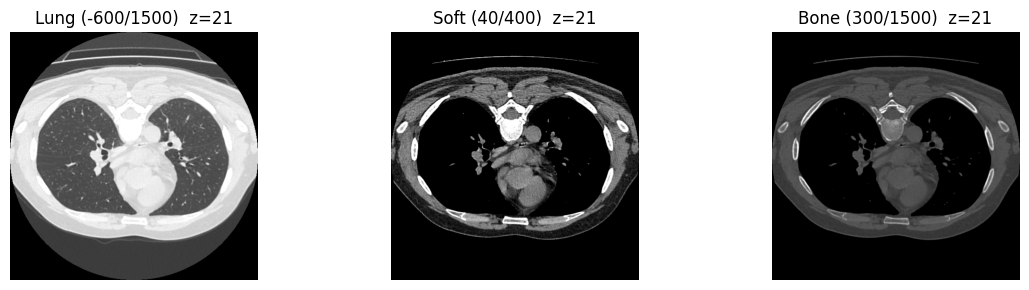

Preview: study_0002.nii.gz


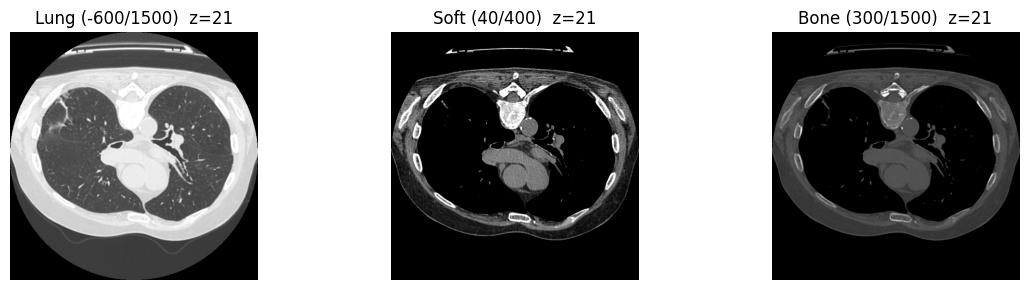

Preview: study_0003.nii.gz


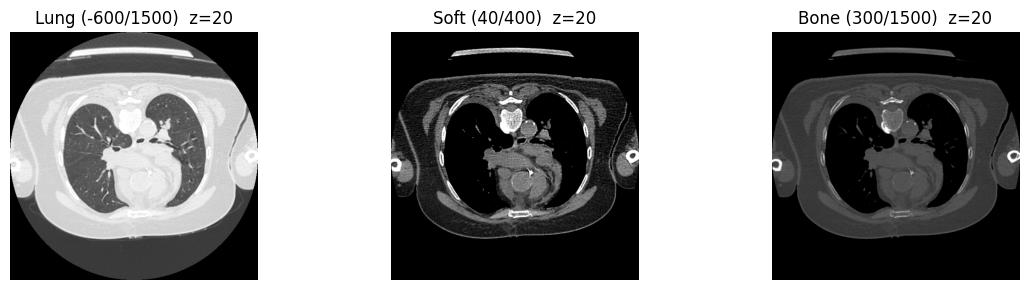

In [24]:
def quick_preview(path):
    """Рендерит центральный срез в трёх пресетах WL/WW для выбранного файла."""
    vol, _, _ = load_nifti_volume(path)
    z = vol.shape[0] // 2
    presets = [(-600,1500), (40,400), (300,1500)]
    titles  = ["Lung", "Soft", "Bone"]
    plt.figure(figsize=(12,3))
    for i,(wl,ww) in enumerate(presets):
        plt.subplot(1,3,i+1)
        plt.imshow(apply_window(vol[z], wl, ww), cmap="gray")
        plt.title(f"{titles[i]} ({wl}/{ww})  z={z}")
        plt.axis("off")
    plt.tight_layout(); plt.show()

# Вызов (по первым трём сериям):
for p in nifti_paths[:3]:
    print("Preview:", os.path.basename(p))
    quick_preview(p)

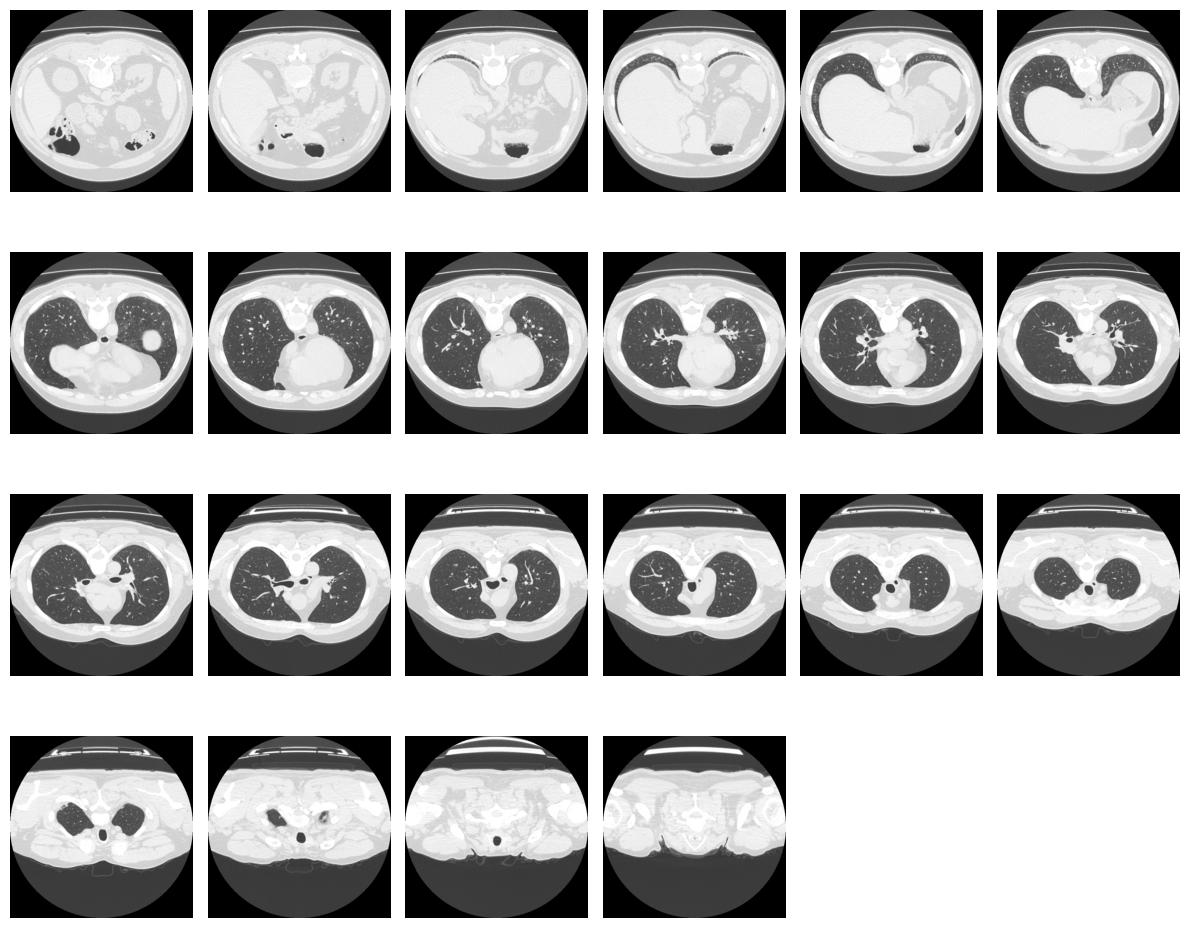

In [25]:
def show_montage(volume, step=20, wl=-600, ww=1500, cols=6):
    """Показывает каждый n-й срез из тома."""
    samples = volume[::step]
    rows = int(np.ceil(len(samples)/cols))
    plt.figure(figsize=(12, 2.5*rows))
    for i, img in enumerate(samples):
        plt.subplot(rows, cols, i+1)
        plt.imshow(apply_window(img, wl, ww), cmap="gray")
        plt.axis("off")
    plt.tight_layout(); plt.show()

# Вызов:
vol0, _, _ = load_nifti_volume(nifti_paths[0])
show_montage(vol0, step=max(1, vol0.shape[0]//16), wl=-600, ww=1500)

In [26]:
import ipywidgets as widgets
from IPython.display import display

def interactive_view(path):
    """Интерактивный просмотр тома по Z с окнами WL/WW."""
    vol, _, _ = load_nifti_volume(path)
    zmax = vol.shape[0]-1
    def _show(z=0, wl=-600, ww=1500):
        plt.figure()
        plt.imshow(apply_window(vol[z], wl, ww), cmap="gray")
        plt.title(f"{os.path.basename(path)} | z={z} | WL/WW={wl}/{ww}")
        plt.axis("off"); plt.show()
    s_z  = widgets.IntSlider(min=0, max=zmax, value=zmax//2, step=1, description="Slice")
    s_wl = widgets.IntSlider(min=-1000, max=1000, value=-600, step=10, description="WL")
    s_ww = widgets.IntSlider(min=100, max=3000, value=1500, step=50, description="WW")
    out = widgets.interactive_output(_show, {"z": s_z, "wl": s_wl, "ww": s_ww})
    display(widgets.VBox([s_z, s_wl, s_ww]), out)

# Вызов:
interactive_view(nifti_paths[0])

Output()